In [ ]:
%matplotlib notebook

from agent import DummyAgent, HumanAgent, SLAgent
from renju import run_test, Player
import nnet

In [ ]:
def pit(black, white):
    while True:
        result, game = run_test(black, white)
        if result == Player.BLACK:
            print('Black win')
        elif result == Player.WHITE:
            print('White win')
        else:
            print('Draw')


        is_ended = 0
        while True:
            ans = input('Play again? y/n')
            if ans == 'y':
                break
            elif ans == 'n':
                is_ended = 1
                break
            else:
                print('Invalid input. Eneter y/n')


        if is_ended:
            break

    return game 


In [ ]:
import tensorflow
tensorflow.reset_default_graph()
human = SLAgent('white', nnet.PolicyNet(), modelfile='models/second_model')
network = SLAgent('black', nnet.PolicyNet(), modelfile='models/first_model_3epochs')

In [ ]:
game = pit(network, human)

# keras policy network

In [ ]:
import keras
from keras.layers import Input, Conv2D, Flatten, Reshape
from keras.layers import Activation, BatchNormalization
from keras.models import Model

# clear previous graphs and close session
keras.backend.clear_session()

inp = Input(shape=(15, 15, 4))
x = Conv2D(16, (3, 3), padding='same')(inp)
x = Conv2D(16, (3, 3), padding='same')(x)
x = BatchNormalization()(Activation('relu')(x))

x = Conv2D(32, (3, 3), padding='same')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(Activation('relu')(x))

x = Conv2D(64, (3, 3), padding='same')(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = Conv2D(1, (1, 1), padding='same')(x)

probs = Activation('softmax')(x)
predictions = Reshape((225,))(probs)

In [ ]:
model = Model(inputs=inp, outputs=[predictions])

In [ ]:
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
model = keras.models.load_model('model01.hdf5')

In [ ]:
import numpy
from tqdm import tqdm
import util

test = []
target = []
games = []

with open('data/raw/train.renju') as f:
    for game in tqdm(f.readlines()[:100]):
        games.append(game)
        
        res, *moves = game.split()
        state = numpy.zeros((15, 15, 4), dtype=numpy.uint8)

        print(res)
        if res == 'white':
            player = -1
        elif res == 'black':
            state[..., 2] = 1
            player = 1
        else:
            continue

        for move in moves:
            i, j = util.to_pos(move)

            if player == 1:
                print('writing state')
                print(state[...,0])
                print()
                print(state[...,1])
                print()
                print(state[...,2])
                test.append(numpy.copy(state))
                target.append(i * 15 + j)
                state[i, j, 0] = 1

            if player == -1:
                state[i, j, 1] = 1

            player = -player

In [ ]:
model.summary()

In [ ]:
print(model.evaluate(x=numpy.array(test[:10000]), y=numpy.array(target[:10000]), verbose=1))

In [ ]:
move=model.predict(x=numpy.array(test[0]).reshape((1, 15, 15, 4)))

In [ ]:
print(move)

In [ ]:
import matplotlib.pyplot as plt
i = 3

plt.subplot(131)
plt.imshow(test[i][..., 0], cmap='gray')
plt.subplot(132)
plt.imshow(test[i][..., 1], cmap='gray')
plt.subplot(133)
plt.imshow(test[i][..., 2], cmap='gray')
print(test[i][..., 2])

In [ ]:
for i in range(10):
    print(test[i][...,0])
    print()
    print(test[i][...,1])
    print()
    print(test[i][...,2])

In [ ]:
len(test)

In [ ]:
import nnet

In [ ]:
len(games)

In [ ]:
states_count = 0
for game in games:
    res, *moves = game.split()
    if res == 'black':
        states_count += int(numpy.ceil(len(moves) / 2))
    if res == 'white':
        states_count += int(numpy.floor(len(moves) / 2))


generator = nnet.DataGenerator(games, states_count, batch_size=1).generate()

step = 0
for res in generator:
    print(f'------------------- step {step} ------------------------')
    print(res[0][...,0])
    print()
    print(res[0][...,1])
    print()
    print(res[0][...,2])
    print()
    step += 1
    if step == 15:
        break


In [ ]:
import keras
import numpy
import util

In [ ]:
model = keras.models.load_model('models/model03.hdf5')
X_test = []
y_test = []
with open('data/test.renju') as file:
    for game in file:
        res, *moves = game.split()
        state = numpy.zeros((15, 15, 4), dtype=numpy.uint8)

        if res == 'white':
            player = -1
        elif res == 'black':
            state[..., 2] = 1
            player = 1
        else:
            continue

        for move in moves:
            i, j = util.to_pos(move)

            if player == 1:
                X_test.append(numpy.copy(state))
                y_test.append(i * 15 + j)
                state[i, j, 0] = 1

            if player == -1:
                state[i, j, 1] = 1

            player = -player

X_test = numpy.array(X_test)
y_test = numpy.array(y_test)

In [ ]:
print(len(y_test))

In [ ]:
model = keras.models.load_model('models/model.augmentations.01.hdf5')
pred = model.predict(X_test[:100000], verbose=1)

# Augmentations

In [ ]:
import numpy
import matplotlib.pyplot as plt

In [ ]:
# to util
def get_rotation_map():
    '''returns array with pos (i, j) -> (i', j') maping after k rotations'''
    rotation_map = numpy.zeros((4, 15, 15, 2), dtype=int)
    for m in range(225):
        i, j = m // 15, m % 15
        state = numpy.zeros((15, 15))
        state[i, j] = 1
        for k in range(4):
            rotated_state = numpy.rot90(state, k)
            pos = numpy.argmax(rotated_state)
            rotation_map[k][i, j] = pos // 15, pos % 15
    return rotation_map

In [ ]:
rotation_map = get_rotation_map()
def augment_state(state, pos):
    '''
    Randomly shift and/or rotate
    '''
    # find borders
    (min_x, max_x), (min_y, max_y) = (0, 14), (0, 14)
    ind_y, ind_x = numpy.nonzero(state)

    if ind_x.size > 0:
        min_x, max_x = numpy.min(ind_x), numpy.max(ind_x)
        min_x = min(min_x, pos[1])
        max_x = max(max_x, pos[1])
    if ind_y.size > 0:
        min_y, max_y = numpy.min(ind_y), numpy.max(ind_y)
        min_y = min(min_y, pos[0])
        max_y = max(max_y, pos[0])
    
    # do shift
    if numpy.random.uniform(0, 1) < .5:
        x_shift = numpy.random.randint(-min_x, 15 - max_x)
        y_shift = numpy.random.randint(-min_y, 15 - max_y)
        state = numpy.roll(state, (y_shift, x_shift), axis=(0, 1))
        pos = pos[0] + y_shift, pos[1] + x_shift
        
    # do rotation
    rotations_n = numpy.random.randint(4)
    state = numpy.rot90(state, rotations_n)
    pos = tuple(rotation_map[rotations_n][pos])
    
    # do reflection
    if numpy.random.uniform(0, 1) < .5:
        state = numpy.fliplr(state)
        pos = pos[0], 14 - pos[1]

    return state, pos

In [ ]:
# TESTING

state = numpy.zeros((15, 15))
state[3, 4] = 1
state[7, 7] = 1
state[5, 9] = 1
state[8, 8] = 1
state[14, 1] = 1

pos = (9, 9)

#plt.subplot(121)
#plt.imshow(state, cmap='gray')

# state, new_pos = augment_state(state, pos)
# state[new_pos] = 1

# plt.subplot(122)
# plt.imshow(state, cmap='gray')

In [ ]:
state = numpy.zeros((15, 15, 4))
state[3, 4, 0] = 1
state[7, 7, 0] = 1
state[5, 9, 0] = 1
state[8, 8, 0] = 1
state[14, 1, 0] = 1

state[3, 4, 1] = 1
state[7, 7, 1] = 1
state[5, 9, 1] = 1
state[8, 8, 1] = 1
state[14, 5, 1] = 1



plt.subplot(221)
plt.imshow(state[..., 0], cmap='gray')
plt.subplot(222)
plt.imshow(state[..., 1], cmap='gray')

state = numpy.rot90(state, 1, axes=(0, 1))

plt.subplot(223)
plt.imshow(state[..., 0], cmap='gray')
plt.subplot(224)
plt.imshow(state[..., 1], cmap='gray')

# random sampling of pos

In [ ]:
import numpy as np
import keras

In [ ]:
a = np.array([1, 2, 3, 4, 5, 10])
print(np.random.choice(a, p=[1., .0, .0, .0]))

In [ ]:
model = keras.models.load_model('./models/model.augmentations.01.hdf5')
state = np.random.randint(2, size=)

In [ ]:
np.arange(10)

# Simple tree search with policy network

In [10]:
import numpy
import renju
import copy
import sys
import keras
import matplotlib.pyplot as plt

In [2]:
class Node:
    def __init__(self, state, prob):
        self.state = state
        self.prob = prob
        self.children = []

In [47]:
class Tree:
    def __init__(self, model, max_depth=10, max_actions=5):
        self.model = model
        self.max_depth = max_depth
        self.max_actions = max_actions
        self.game = None

    def get_prob(self, game):
        """
        return probabilities of actions from current state
        """
        self.game = copy.deepcopy(game)
        state = self.game.state()
        root = Node(state, prob=1)
        self.search(cur=root, depth=0)

        return root.children

    def search(self, cur, depth):
        """
        return action to take from this node
        """

        if depth == self.max_depth:
            return

        state = cur.state
        probs = self.model.predict(state.reshape((1, 15, 15, 4))).reshape((15, 15))

        # get only valid nodes and normalize
        valid_actions = probs * self.game.valid()
        prob_sum = numpy.sum(valid_actions)
        if prob_sum:
            valid_actions /= prob_sum
        else:
            print('All probabilities are zeros. Do something!', file=sys.stderr)
            exit(1)

        # create max_actions children
        actions = numpy.unravel_index(valid_actions.argsort(), valid_actions.shape)[:self.max_actions]
        max_prob = -numpy.inf

        for (i, j) in actions:
            # make move to (i, j), after move undo it.
            child = Node(self.game.state(), prob=numpy.log(valid_actions[i, j]))
            self.game.move((i, j))
            self.search(child, depth + 1)
            self.game.undo()

            if child.prob > max_prob:
                max_prob = child.prob

            node.children.append(child)

        if depth:
            node.prob += max_prob


In [33]:
game = renju.Game()
model = keras.models.load_model('models/model03.hdf5')

In [48]:
test_tree = Tree(model)

In [29]:
def print_state(state):
    plt.subplot(131)
    plt.title('Yours')
    plt.imshow(state[..., 0], cmap='gray')
    
    plt.subplot(132)
    plt.title('Opponent')
    plt.imshow(state[..., 1], cmap='gray')
    
    plt.subplot(133)
    plt.title('Is black')
    if state[0, 0, 2]:
        print('black now')
    plt.imshow(state[..., 2], cmap='gray', vmin=0, vmax=1)
    
    plt.show()

In [75]:
game = renju.Game()
game.move((7,7))
game.move((8, 7))

black now


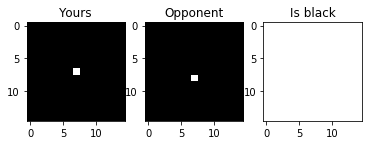

In [76]:
print_state(game.state())

In [87]:
prob = model.predict(game.state().reshape((1, 15, 15, 4)))
prob.ravel()[142]

0.38947028

In [88]:
np.unravel_index(prob.ravel().argsort()[-1], (15, 15))

(9, 8)

In [59]:
import numpy as np

arr = np.array([[5, 2, 4],
[3, 3, 3],
[6, 1, 2]])
it = np.dstack(np.unravel_index(np.argsort(arr.ravel()), (3, 3)))
print(it)

[[[2 1]
  [0 1]
  [2 2]
  [1 0]
  [1 1]
  [1 2]
  [0 2]
  [0 0]
  [2 0]]]


In [58]:
for (i, j) in it[0]:
    print(i, j)

2 1
0 1
2 2
1 0
1 1
1 2
0 2
0 0
2 0


In [71]:
a = np.array([1, 2, 3])
b = np.array([5, 6, 7])
np.column_stack((a,b))

array([[1, 5],
       [2, 6],
       [3, 7]])

In [72]:
for (i,j) in np.column_stack((a, b)):
    print(i,j)

1 5
2 6
3 7


In [74]:
(a, b)

(array([1, 2, 3]),)

In [1]:
import mcts

Using TensorFlow backend.


In [3]:
%%timeit
mcts.test_launch()

7.3 s ± 865 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# port tree to c++

In [1]:
import numpy as np

In [2]:
arr = np.random.randint(2, size=(1, 15, 15, 4))

In [3]:
arr

array([[[[1, 0, 0, 0],
         [0, 1, 0, 0],
         [1, 1, 1, 1],
         [0, 0, 0, 0],
         [1, 0, 1, 1],
         [1, 1, 0, 0],
         [1, 1, 1, 1],
         [1, 1, 1, 0],
         [1, 1, 0, 0],
         [1, 1, 0, 1],
         [0, 0, 0, 1],
         [1, 1, 1, 1],
         [0, 0, 0, 0],
         [1, 0, 0, 0],
         [1, 0, 1, 1]],

        [[0, 1, 0, 0],
         [0, 1, 1, 0],
         [0, 0, 1, 1],
         [1, 0, 1, 1],
         [0, 0, 1, 1],
         [1, 0, 1, 1],
         [0, 0, 1, 1],
         [0, 0, 0, 0],
         [1, 1, 1, 1],
         [0, 1, 1, 0],
         [1, 0, 0, 0],
         [0, 1, 0, 0],
         [1, 0, 1, 1],
         [0, 1, 1, 1],
         [1, 0, 0, 0]],

        [[1, 0, 1, 1],
         [1, 0, 1, 1],
         [1, 0, 1, 1],
         [1, 0, 0, 1],
         [0, 0, 0, 0],
         [1, 0, 1, 1],
         [0, 1, 0, 0],
         [1, 1, 1, 1],
         [1, 0, 1, 0],
         [1, 0, 1, 1],
         [1, 1, 1, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 0],
       

# c++ port of tree

In [1]:
import numpy as np
import keras

Using TensorFlow backend.


In [2]:
model = keras.models.load_model('models/model03.hdf5')
board = np.zeros((1, 15, 15, 4))

print(model.predict(board))

[[2.06568226e-01 1.06625315e-02 2.12555612e-03 1.83567242e-03
  2.13115616e-03 2.82744318e-03 3.26621043e-03 3.58152855e-03
  4.58812434e-03 4.99216001e-03 4.51299222e-03 7.02464860e-03
  2.01956816e-02 3.95977162e-02 7.75009466e-05 1.11337733e-02
  2.64280476e-04 8.55023172e-05 9.25901550e-05 1.52147841e-04
  1.46652179e-04 2.18556961e-04 2.60192115e-04 3.55720549e-04
  3.71140253e-04 7.66325626e-04 2.67171557e-03 2.49332841e-03
  2.72282073e-03 3.18590282e-05 2.86148721e-03 6.18652048e-05
  4.21563927e-05 1.63705961e-04 7.42348842e-04 1.04413566e-03
  2.19894690e-03 2.38486147e-03 1.60462840e-03 7.90511142e-04
  4.06524632e-04 8.06127151e-04 3.75493476e-03 1.53258478e-03
  2.60982642e-06 3.23749660e-03 1.32735062e-04 2.00870767e-04
  1.32536283e-03 7.51121249e-03 1.09934034e-02 1.69335604e-02
  1.76119134e-02 9.89758875e-03 5.64586883e-03 1.09661836e-03
  1.91291585e-03 4.86293249e-03 3.34520708e-03 3.70959401e-06
  4.18896880e-03 1.61828983e-04 1.16264840e-04 6.21963991e-04
  6.7202

In [11]:
import tensorflow as tf
import numpy as np

sess = tf.InteractiveSession()

a = np.random.randint(2, size=(15, 15, 2))
b = np.random.randint(2, size=(15, 15, 1))

#c = tf.stack([a, b], 0)
c = tf.concat([a, b], 2)
print(c.eval())

[[[0 0 1]
  [1 1 0]
  [0 1 0]
  [0 1 1]
  [0 0 0]
  [0 1 0]
  [0 1 1]
  [0 0 0]
  [0 0 1]
  [1 1 0]
  [0 1 1]
  [1 0 1]
  [1 1 1]
  [0 1 1]
  [0 1 0]]

 [[0 1 1]
  [1 0 1]
  [1 0 0]
  [0 1 0]
  [0 0 1]
  [0 0 1]
  [1 1 1]
  [1 1 0]
  [1 1 0]
  [0 1 1]
  [1 1 0]
  [1 1 0]
  [1 1 0]
  [0 0 0]
  [1 0 0]]

 [[1 0 0]
  [0 0 0]
  [1 0 0]
  [0 0 0]
  [0 1 0]
  [0 0 0]
  [1 1 0]
  [0 0 0]
  [1 0 1]
  [1 0 1]
  [0 0 1]
  [0 0 1]
  [1 1 0]
  [0 1 1]
  [0 1 1]]

 [[1 1 1]
  [0 0 1]
  [0 0 0]
  [1 0 0]
  [1 0 1]
  [0 0 0]
  [1 1 0]
  [0 1 0]
  [0 0 1]
  [1 0 1]
  [1 1 1]
  [0 1 1]
  [0 0 0]
  [0 0 0]
  [1 0 1]]

 [[1 0 1]
  [0 1 1]
  [0 1 0]
  [1 0 0]
  [1 1 1]
  [1 0 1]
  [1 0 0]
  [0 0 0]
  [0 1 0]
  [1 0 1]
  [0 1 0]
  [1 0 0]
  [1 1 0]
  [1 0 1]
  [1 1 1]]

 [[1 0 1]
  [0 0 1]
  [1 1 0]
  [0 0 1]
  [1 1 1]
  [1 0 0]
  [0 1 0]
  [0 1 0]
  [0 1 0]
  [1 0 0]
  [1 0 0]
  [0 1 1]
  [1 0 0]
  [0 0 0]
  [0 0 0]]

 [[1 1 1]
  [0 0 1]
  [0 0 0]
  [1 0 1]
  [0 0 1]
  [1 0 1]
  [0 1 0]
  [0 1 0]
  [1 1 0

In [13]:
print(a[...,0])
print()
print(a[...,1])
print()
print(b[...,0])

[[0 1 0 0 0 0 0 0 0 1 0 1 1 0 0]
 [0 1 1 0 0 0 1 1 1 0 1 1 1 0 1]
 [1 0 1 0 0 0 1 0 1 1 0 0 1 0 0]
 [1 0 0 1 1 0 1 0 0 1 1 0 0 0 1]
 [1 0 0 1 1 1 1 0 0 1 0 1 1 1 1]
 [1 0 1 0 1 1 0 0 0 1 1 0 1 0 0]
 [1 0 0 1 0 1 0 0 1 1 0 1 1 1 1]
 [0 1 0 1 1 1 0 0 0 1 0 0 0 1 1]
 [1 0 0 0 0 0 1 0 1 0 0 1 1 0 0]
 [1 1 0 0 0 0 0 0 1 1 0 1 1 1 1]
 [0 1 0 0 1 0 0 1 0 0 0 0 0 1 1]
 [1 0 1 1 1 0 1 1 0 1 1 0 1 0 0]
 [0 0 1 1 1 0 0 0 1 1 0 0 1 1 0]
 [0 1 0 1 1 1 0 1 0 1 1 0 1 0 1]
 [0 1 0 1 1 0 0 1 1 1 0 1 1 1 0]]

[[0 1 1 1 0 1 1 0 0 1 1 0 1 1 1]
 [1 0 0 1 0 0 1 1 1 1 1 1 1 0 0]
 [0 0 0 0 1 0 1 0 0 0 0 0 1 1 1]
 [1 0 0 0 0 0 1 1 0 0 1 1 0 0 0]
 [0 1 1 0 1 0 0 0 1 0 1 0 1 0 1]
 [0 0 1 0 1 0 1 1 1 0 0 1 0 0 0]
 [1 0 0 0 0 0 1 1 1 1 0 0 1 1 1]
 [0 1 0 1 1 0 1 0 0 0 0 0 1 1 1]
 [0 0 0 0 1 0 0 1 0 1 1 1 1 0 1]
 [1 0 1 1 0 0 1 1 1 1 0 1 0 1 0]
 [1 0 1 0 1 1 0 0 1 1 0 1 0 1 0]
 [0 0 1 0 0 1 1 1 1 1 1 1 1 0 0]
 [0 0 0 0 0 1 1 1 1 0 0 1 0 1 0]
 [0 1 0 1 1 1 0 1 1 0 1 0 1 0 1]
 [0 1 0 0 0 1 0 0 1 0 0 0 0 1 0]]

[[1 0 

In [16]:
arr = c.eval()
print(a[...,0] - arr[..., 0])
print()
print(a[...,1] - arr[..., 1])
print()
print(b[...,0] - arr[..., 2])

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]

[[0 0 

In [2]:
import keras
import renju
model = keras.models.load_model('models/model03.hdf5')

In [5]:
%%time
game = renju.Game()
game.move((7, 7))
game.move((7, 8))
game.move((9, 10))
game.move((12, 12))
game.move((14, 14))
game.move((5, 8))


for i in range(10000):
    model.predict(game.state().reshape((1, 15, 15, 4)))

CPU times: user 58.3 s, sys: 4.36 s, total: 1min 2s
Wall time: 27.2 s


In [6]:
import agent

In [5]:
import numpy as np
import renju
import util
import matplotlib.pyplot as plt
from tqdm import tqdm


processed = open('data/new_train.renju', 'w')
count = 0
i = 0

with open('data/train.renju') as file:
    for line in file.readlines():
        res, *moves = line.split()
        game = renju.Game()
        if res == 'white' or res == 'black':
            for move in moves:
                try:
                    game.move(util.to_pos(move))
                except AssertionError:
                    print('Assertion Error (invalid pos)')
                    count += 1
                    break
                    
            if game.result() != renju.Player.NONE:
                processed.write(line)
                processed.write('\n')
            else:
                count += 1
            i += 1
            if i % 10000 == 0:
                print(f'i={i}, count={count}')
                
        else:
            continue

i=10000, count=3940
i=20000, count=8328
i=30000, count=12483
i=40000, count=17142
i=50000, count=20712
i=60000, count=24479
i=70000, count=27978
i=80000, count=32591
i=90000, count=37701
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
i=100000, count=47677
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
i=110000, count=57621
Assertion Error (invalid pos)
Assertion Error (in

Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion 

i=470000, count=415717
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
i=480000, count=425646
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
i=490000, count=435561
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
i=500000, count=445481
Assertio

Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
i=710000, count=654179
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
i=720000, count=6

Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
i=870000, count=813505
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
i=880000, count=823445
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid

Assertion Error (invalid pos)
i=1230000, count=1125080
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
i=1240000, count=1132541
Assertion Error (invalid pos)
i=1250000, count=1139928
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
i=1260000, count=1146797
Assertion Error (invalid pos)
i=1270000, count=1153576
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
i=1280000, count=1160588
Assertion Error (invalid pos)
Assertion Error (invalid pos)
i=1290000, count=1167543
Assertion Error (invalid pos)
i=1300000, count=1174745
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
i=1310000, count=1182123
Assertion Error (invalid pos)
Assertion Error (invalid pos)
Assertion Error (invalid pos)
i=1320000, count=1189246
Assertion Error (invalid pos)


KeyboardInterrupt: 

In [ ]:
test_game = renju.Game()
for move in 'h8 j8 j7 g9 g10 h10 h7 j9 j11 k8 l7 k7 h9 h6 k6 j5 g7 f7 l9 m8 n8 l5 l10 l8 m9 k11 o9 k9 k10 n9 n10 o10 h12 g13 o7 j10 m10 k12 j12 l12 m11 l13 l11 m14 n15 h5 o8 m7 n6 m5 m6 k5'.split():
    print(move)
    test_game.move(util.to_pos(move))
    
plt.imshow(test_game.board(), cmap='gray')